In [ ]:

import numpy as np
import pandas as pd
import re
import pickle
import random
from tqdm import tqdm_notebook
import torch
from torch import nn
import torch.nn.functional as F


In [ ]:
SEED=2019 #so that o/p will be same when we run multiple times
torch.manual_seed(SEED)

### **Load Dataset**

In [ ]:
with open("dialogs_dataset","rb") as f:#this dataset is just the subset of taskmaster dataset bcs google colab may not handle whole data
    dialogs=pickle.load(f)

In [ ]:
len(dialogs)

64776

In [ ]:
random.sample(dialogs,10)

[" no, I don't think so",
 'Thanks! Do you have a cost estimate?',
 "I haven't used my Uber credit this month, have I?",
 'Edwards South Gate Stadium',
 'I can do that',
 'Hey, I need movie tickets for two for tonight',
 'Sounds good, when are they going to be able to take a look at my truck?',
 "I don't want want to break the bank so Get a speical if they have it",
 'What is the total? ',
 'I would like all crust toppers on this large thin pizza']

## 3) Preprocessing and exploring the text data

3.1 Text cleaning



In [ ]:
dialogs_clean=[]
for i in dialogs:
  #remove everything except alphabets
  i=re.sub(r"[^a-zA-Z]"," ",i)
  i=i.lower()
  dialogs_clean.append(i)

In [ ]:
random.sample(dialogs_clean,10)

[' thanks for trying',
 ' can you tell me the different types of milk they offer ',
 'ok  that sounds good',
 'i would never think to order that  but i m sure it s great',
 'yes  ask if they have italian sausage  i may get a meat lover kind of pizza if they have enough type of meat',
 ' do you want anything  you can order yourself something if you want',
 'korger in portsmouth',
 'yes  that s fine',
 'its ok  i will probably go saturday',
 'well i m coming from newark airport and need a ride to teaneck nj']

# 3.2 Finding Word count
-to find rear and repeating words


In [ ]:
all_words=" ".join(dialogs_clean).split()
word_dict={}
for word in all_words:
  if word in word_dict:
    word_dict[word]+=1
  else:
    word_dict[word]=1
print(len(word_dict))

10559


In [ ]:
# prepare a dataframe
words_df=pd.DataFrame({'word':list(word_dict.keys()),'count':list(word_dict.values())})
#sort values in increaing of count
words_df=words_df.sort_values(by=['count'])
# reset dataframe index
words_df=words_df.reset_index(drop=True)

In [ ]:
len(words_df)

10559

In [ ]:
words_df.head(10) #rear tokens

,word,count
0,tabs,1
1,mangos,1
2,acquarium,1
3,lucille,1
4,sizzler,1
5,funky,1
6,goodyear,1
7,separately,1
8,heist,1
9,revere,1


In [ ]:
words_df.tail(10) #frequent

,word,count
10549,s,6713
10550,is,6938
10551,for,7709
10552,it,8943
10553,that,11060
10554,you,12215
10555,a,13391
10556,to,14003
10557,the,15414
10558,i,25607


# find and replace rear words with "unknown" token

In [ ]:
#this is to reduce vocabulary size and that will inturn speed up the training process bcs the model will have smaller set of vocabulary to give an o/p in each time step
# user specified threhold value
rare_threh=4
# get % of rare words in vocabulary
rare_words_count=len(words_df[words_df['count']<rare_threh]['word'])
total_words_count=len(words_df)
rare_dist=rare_words_count/total_words_count
rare_cover=words_df[words_df['count']<rare_threh]['count'].sum()/words_df['count'].sum()

In [ ]:
print(f"Rare words distribution in vocabulary:{rare_dist*100:.2f}")
print(f"Rare words coverage in the corpus:{rare_cover*100:.2f}")

Rare words distribution in vocabulary:67.73
Rare words coverage in the corpus:2.06


In [ ]:
#extract rare words in a list
rare_words=words_df[words_df['count']<rare_threh]['word'].tolist()
print(rare_words)


['tabs', 'mangos', 'acquarium', 'lucille', 'sizzler', 'funky', 'goodyear', 'separately', 'heist', 'revere', 'liam', 'nesson', 'voice', 'purgacito', 'salvadorian', 'brisas', 'westing', 'muh', 'somebody', 'knoxville', 'rotor', 'kayne', 'prperly', 'selecting', 'arms', 'luckily', 'attleboro', 'prove', 'reef', 'belinda', 'musician', 'cancelation', 'dg', 'availablity', 'ballgame', 'jj', 'bayside', 'reasons', 'crumble', 'shakira', 'edition', 'saline', 'receiving', 'stag', 'cakebread', 'rented', 'celica', 'ness', 'cafora', 'portsmouth', 'korger', 'admit', 'hammerhead', 'ful', 'bonanzo', 'beasts', 'crimes', 'grindelwald', 'caffichino', 'ordere', 'leap', 'lucas', 'margueritas', 'cock', 'eden', 'genres', 'driskill', 'indecisive', 'emagine', 'brissago', 'saturn', 'evergree', 'coversation', 'idk', 'reeady', 'thingy', 'creekes', 'maserati', 'ghibhi', 'marguerita', 'mainstrasse', 'scotti', 'smalls', 'victorian', 'frappucinno', 'situations', 'authorization', 'gakus', 'spinasse', 'liner', 'redone', 'ci

 the technique that we will use to replace the rare tokens with in the dataset with special token known as unknown token ("<unk>")

In [ ]:
##Example
#specify rare words
r_words=["day","book"]
#build pattern
pattern=""
for i in r_words:
  pattern+="{}|".format(i)
print(pattern)


day|book|


In [ ]:
#removing last ele which is '|'
pattern=pattern[:-1]
print(pattern)

day|book


In [ ]:
#replacing arre words with <unk>
sents=["its been a good day after reading that","book in the morning"]
for d in sents:
  text=re.sub(pattern,"<unk>",d)
  print(text)

its been a good <unk> after reading that
<unk> in the morning


In [ ]:
# # create a text pattern from rare words like word1|word2|word3
# pattern=""
# for i in rare_words:
#   pattern+="{}|".format(i)
# pattern=pattern[:-1]


In [ ]:
# #empty list
# dialogs_clean_v2=[]

# for d in tqdm_notebook(dialogs_clean):
#   text=re.sub(pattern,"<unk>",d)
#   dialogs_clean_v2.append(text)

<ipython-input-17-53b3f7d844fe>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for d in tqdm_notebook(dialogs_clean):


  0%|          | 0/64776 [00:00<?, ?it/s]

In [ ]:
pattern = r'\b(?:' + '|'.join(re.escape(word) for word in rare_words) + r')\b'

# Now proceed with the replacement as before
dialogs_clean_v2 = []
for d in tqdm_notebook(dialogs_clean):
    text = re.sub(pattern, "<unk>", d)
    dialogs_clean_v2.append(text)

print(dialogs_clean_v2[:3])  # Print the first 3 elements for inspection

<ipython-input-65-ae034cc27adc>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for d in tqdm_notebook(dialogs_clean):


  0%|          | 0/64776 [00:00<?, ?it/s]

['hi  i m looking to book a table for korean <unk>', 'somewhere in southern nyc  maybe the east village ', ' we don t want to sit at the bar  but anywhere else is fine']


In [ ]:
dialogs_clean_v2[520:530]

['does it serve traditional chinese dessert ',
 'how much extra time to reach <unk>  ',
 'ok lets reserve a table for dinner at <unk>',
 'hello i need to get a car please',
 'holiday inn chicago <unk> park <unk> <unk>  convention center drive  <unk> park  il',
 'bowling alley  <unk> highway  <unk> park  il',
 'what types of cars does uber have ',
 'what s the price difference ',
 'ok get me the cheapest please',
 'ok then get me the next level']

# 3 Data Preparation

3.1 prepare sequences

<Axes: >

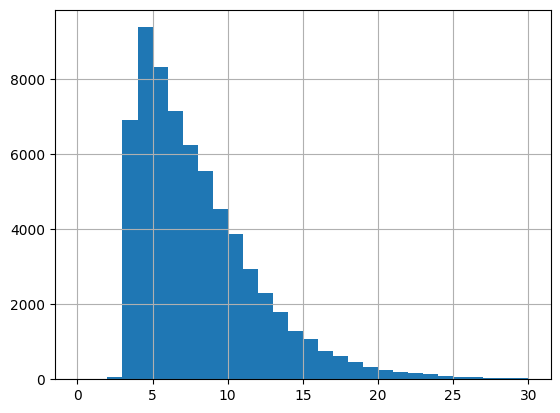

In [ ]:
#plot sequences length
text_word_count=[]
for i in dialogs_clean_v2:
  text_word_count.append(len(i.split()))
pd.Series(text_word_count).hist(bins=30,range=(0,30))

In [ ]:
#fxn to create seq of equal len
def create_seq(text,seq_len=5):
  sequences=[]
  if len(text.split())>seq_len:
    for i in range(len(text.split())-seq_len):
      seq=text.split()[i:i+seq_len]
      sequences.append(" ".join(seq))
    return sequences
  else:
    return [text]

In [ ]:
# create seq of equal len
seqs=[create_seq(i) for i in dialogs_clean_v2]

In [ ]:
print(seqs[:10])

['hi i m looking to', 'i m looking to book', 'm looking to book a', 'looking to book a table', 'to book a table for', 'book a table for korean', 'somewhere in southern nyc maybe', 'in southern nyc maybe the', 'southern nyc maybe the east', 'we don t want to']


In [ ]:
# merging in to single big list instead of list of list
seqs=[item for sublist in seqs for item in sublist]
# seqs=sum(seqs,[])

In [ ]:
seqs[:15]

['hi i m looking to',
 'i m looking to book',
 'm looking to book a',
 'looking to book a table',
 'to book a table for',
 'book a table for korean',
 'somewhere in southern nyc maybe',
 'in southern nyc maybe the',
 'southern nyc maybe the east',
 'we don t want to',
 'don t want to sit',
 't want to sit at',
 'want to sit at the',
 'to sit at the bar',
 'sit at the bar but']

In [106]:
len(seqs)

215963

In [ ]:
# create input and target seqs
x=[]
y=[]
for i in seqs:
  x.append(" ".join(i.split()[:-1]))
  y.append(" ".join(i.split()[1:]))

In [ ]:
#to show the input and target of teh 1st sentence
x[0],y[0]

('hi i m looking', 'i m looking to')

In [ ]:
x[5583],y[5583]

('you get tickets to', 'get tickets to roma')

4.2 Create-Token Integer mappings

In [ ]:
int2token={}
cnt=1
for w in set(" ".join(dialogs_clean_v2).split()):
  int2token[cnt]=w
  cnt+=1
token2int={t:i for i,t in int2token.items()}


In [ ]:
int2token[7],token2int['served']

('served', 7)

# 4.3 split data in to train and validation sets

In [ ]:
# imput sequences
x_train=x[:15000]
x_val=x[15000:]
#target sequences
y_train=y[:15000]
y_val=y[15000:]


# 4.4 pad sequences

<Axes: >

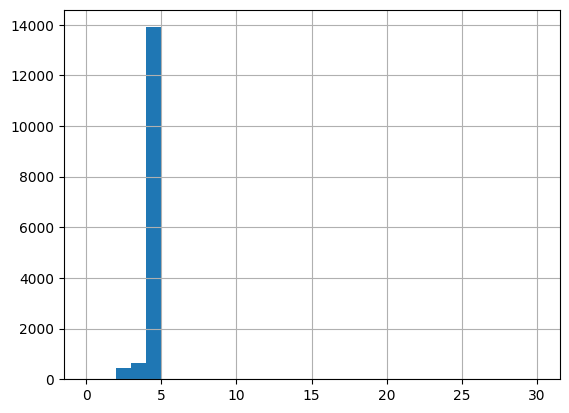

In [ ]:
#plot sequences length in train set
text_word_count=[]
for i in x_train:
  text_word_count.append(len(i.split()))
pd.Series(text_word_count).hist(bins=30,range=(0,30))


In [ ]:
#we can observe that some of them have length less than 5 so we need to pad them in both train and validation set
max_text_len=5
def pad_sequence(seq,n):
  seq=seq.split()
  if len(seq)<n:
    pad_len=n-len(seq)
    for i in range(pad_len):
      seq.append("<pad>")
  return " ".join(seq)
#pad train seq
x_train_padded=[pad_sequence(s,max_text_len) for s in x_train]
y_train_padded=[pad_sequence(s,max_text_len) for s in y_train]
#pad val seq
x_val_padded=[pad_sequence(s,max_text_len) for s in x_val]
y_val_padded=[pad_sequence(s,max_text_len) for s in y_val]

In [ ]:
x_train_padded[:10]

['hi i m looking <pad>',
 'i m looking to <pad>',
 'm looking to book <pad>',
 'looking to book a <pad>',
 'to book a table <pad>',
 'book a table for <pad>',
 'somewhere in southern nyc <pad>',
 'in southern nyc maybe <pad>',
 'southern nyc maybe the <pad>',
 'we don t want <pad>']

In [ ]:
y_train_padded[-10:]

['want to add whip <pad>',
 'to add whip cream <pad>',
 'add whip cream on <pad>',
 'please place the order <pad>',
 'no problem <pad> <pad> <pad>',
 'that is all <pad> <pad>',
 'd like to order <pad>',
 'like to order a <pad>',
 'order online and restaurant <pad>',
 'online and restaurant and <pad>']

<Axes: >

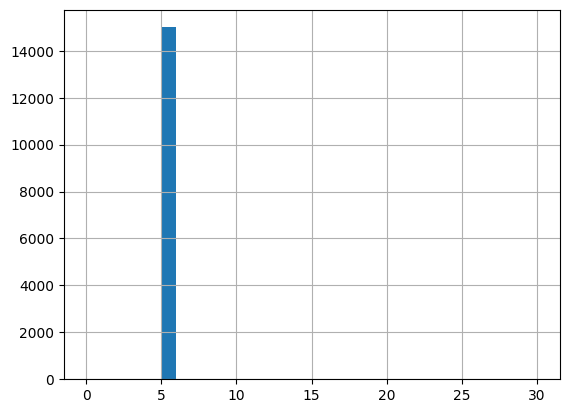

In [ ]:
text_word_count=[]
for i in x_train_padded:
  text_word_count.append(len(i.split()))
pd.Series(text_word_count).hist(bins=30,range=(0,30))

In [ ]:
#update mapping dictionaries
int2token[0]="<pad>"
token2int["<pad>"]=0
#set vocabulary size
vocab_size=len(int2token)

# Convert text sequence to integer sequences

In [ ]:
def get_integer_seq(seq):
  return [token2int[w] for w in seq.split()]

In [ ]:
#convert text seq to integer seq
x_train_int=[get_integer_seq(s) for s in x_train_padded]
y_train_int=[get_integer_seq(s) for s in y_train_padded]

x_val_int=[get_integer_seq(s) for s in x_val_padded]
y_val_int=[get_integer_seq(s) for s in y_val_padded]


In [ ]:
x_train_int[:10]

[[3282, 759, 485, 268, 0],
 [759, 485, 268, 3233, 0],
 [485, 268, 3233, 1234, 0],
 [268, 3233, 1234, 121, 0],
 [3233, 1234, 121, 131, 0],
 [1234, 121, 131, 276, 0],
 [2120, 1252, 2525, 1207, 0],
 [1252, 2525, 1207, 785, 0],
 [2525, 1207, 785, 2607, 0],
 [744, 3320, 916, 3086, 0]]

In [ ]:
y_train_int[:10]

[[759, 485, 268, 3233, 0],
 [485, 268, 3233, 1234, 0],
 [268, 3233, 1234, 121, 0],
 [3233, 1234, 121, 131, 0],
 [1234, 121, 131, 276, 0],
 [121, 131, 276, 2384, 0],
 [1252, 2525, 1207, 785, 0],
 [2525, 1207, 785, 2607, 0],
 [1207, 785, 2607, 45, 0],
 [3320, 916, 3086, 3233, 0]]

In [ ]:
#convert these lists in to numpy arrays
x_train_int=np.array(x_train_int)
y_train_int=np.array(y_train_int)


x_val_int=np.array(x_val_int)
y_val_int=np.array(y_val_int)

x_train_int.shape,y_train_int.shape,x_val_int.shape,y_val_int.shape

((15000, 5), (15000, 5), (200963, 5), (200963, 5))

# now this is ready to pass in to deep learning model-lstm

# 5.1 define model architecture

In [ ]:
# model will 1st take input integer sequences ,which will be passed through embedding layer
# and the o/p dim of the o/p of embedding layer would be 200 i.e it would generate word embedings or word vectors of len 200


#define model architecture

## embedding layer:
## input dim=vocab_size,
## ouput dim=200

## LSTM Layer:
## input dim 200
## hidden units = 256
## layers = 2
## output dim = 256

## Dropout Layer
## input dim=256
## output dim = 256

## fully connected layer
## input dim=256
## ouput dim=vocab_size


###in pytorchhhh
class WordLSTM(nn.Module):

  def __init__(self, n_hidden=256, n_layers=2, drop_prob=0.3, lr=0.001): #lr-learning rate
   super().__init__()
   self.drop_prob=drop_prob
   self.n_layers=n_layers
   self.n_hidden=n_hidden
   self.lr=lr

   self.emb_layer=nn.Embedding(vocab_size,200)
   ##define teh LSTM
   #input data is of shape (batch size,sequence len,no.of features)...
   #by default lstm considers 1st parameter as seq len ,howe ever the batches we pass to this model 1st dim is batch size and 2nd is seq len ,so we need batch_first=True to have batch size 1st
   self.lstm=nn.LSTM(200,n_hidden,n_layers,dropout=drop_prob,batch_first=True)
   ##define the dropout
   self.dropout=nn.Dropout(drop_prob)
   ##define the fully connected layer
   self.fc=nn.Linear(n_hidden,vocab_size)

  def forward(self,x,hidden):
    ''' forward pass through the network
      these inputs are x,and the hidden/cell state is hidden '''

    ## embeddings and lstm_out
    #pass i/p trough embedding layer
    embedded=self.emb_layer(x)
    #get o/p and new hidden state from lstm
    lstm_out,hidden=self.lstm(embedded,hidden) #lstm_out is the tensor of hidden states from all the time steps since we are passing batches of tensors a i/p, hidden is the hidden state from last time step
    ## pass lstm_out through dropout layer
    out=self.dropout(lstm_out)
    #reshape the tensor to the shape(batch-size*seq len,hidden units)
    out=out.reshape(-1,self.n_hidden)
    ## put out through fully connected layer
    out=self.fc(out)
    return out,hidden
  def init_hidden(self,batch_size):
    ''' initialize hiden state '''
    #create two new tensors with sizes n_layers * batch_size * n_hidden,
    #initialised to zero,for hidden state and cell state of LSTM
    weight=next(self.parameters()).data
    if(torch.cuda.is_available()):
        hidden=(weight.new(self.n_layers,batch_size,self.n_hidden).zero_().cuda(),
                weight.new(self.n_layers,batch_size,self.n_hidden).zero_().cuda())
    else:
        hidden=(weight.new(self.n_layers,batch_size,self.n_hidden).zero_(),
                weight.new(self.n_layers,batch_size,self.n_hidden).zero_())
    return hidden





In [ ]:
#define and print model
net=WordLSTM()
print(net)

WordLSTM(
  (emb_layer): Embedding(3409, 200)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=3409, bias=True)
)


In [ ]:
#as we will be passing batches of tensors as i/p to model
#function to generate subsequent batches
def get_batches(arr_x,arr_y,batch_size):
  # iterate through arrays
  prev=0
  for n in range(batch_size,arr_x.shape[0],batch_size):
    #batch for i/p seq
    x=arr_x[prev:n,:]
    #batch for o/p seq
    y=arr_y[prev:n,:]
    prev=n
    yield x,y



# 5.2 start training model

Why tensors?

GPU acceleration: PyTorch tensors can be easily moved to GPUs, which can significantly speed up the training process, especially for large datasets.
Automatic differentiation: PyTorch uses tensors to compute gradients automatically, which is crucial for training deep learning models.
Framework integration: Tensors are the primary data structure used in PyTorch, so using them allows for seamless integration with other parts of the framework.
In summary, torch.from_numpy(x) and torch.from_numpy(y) convert the input and target data from NumPy arrays to PyTorch tensors for use in training a deep learning model. This conversion enables GPU acceleration, automatic differentiation, and efficient model training within the PyTorch framework.



In [ ]:
def train(net,epochs=10,batch_size=32,lr=0.001,print_every=32 ):
  #set initial loss to infinite
  best_val_loss=float('inf')
  #optimizer
  opt=torch.optim.Adam(net.parameters(),lr=lr)
  #loss function
  criterion=nn.CrossEntropyLoss() #in pytorch the way cross entropy is defined is that it also applies softmax operations to it so we dont use softmax Act.fxn at final layer of the model architecture

  #checking if GPU is available
  if(torch.cuda.is_available()):
    #push model to GPU
    net.cuda()
  counter=0
  #set model to train mode
  net.train()

  for e in range(epochs):
    #iterate over batches
    for x,y in get_batches(x_train_int,y_train_int,batch_size):
      counter+=1

      #convert arrays to tensors
      inputs,targets=torch.from_numpy(x),torch.from_numpy(y)
      #push tensors to GPU
      if(torch.cuda.is_available()):
        inputs,targets=inputs.cuda(),targets.cuda()
      #initialise to hidden state
      h=net.init_hidden(batch_size)
      #zero gradients
      net.zero_grad()
      #get the o/p from the model
      output,h=net(inputs,h) # first the o/p at each timestep of all the sequences in the batch and 2nd final hidden states of all the seq in the batch

      #calculate loss and perform backup
      loss=criterion(output,targets.view(-1))
      loss.backward()
      opt.step()
      if counter%print_every==0:  #for every 30 sec step all the validation batches will be passed to the model
        #get validation loss
        val_losses=[]
        net.eval()
        for x,y in get_batches(x_val_int,y_val_int,batch_size):
          x,y=torch.from_numpy(x),torch.from_numpy(y)
          val_h=net.init_hidden(batch_size)

          inputs,targets=x,y
          if(torch.cuda.is_available()):
           inputs,targets=inputs.cuda(),targets.cuda()
          output,val_h=net(inputs,val_h)
          val_loss=criterion(output,targets.view(-1))
          val_losses.append(val_loss.item())
        #save the best model
        if np.mean(val_losses)<best_val_loss:
          best_val_loss=np.mean(val_losses)
          torch.save(net.state_dict(),'saved_weights.pt')
        net.train()
        print("Epoch: {}/{}...".format(e+1,epochs),
      "step: {}...".format(counter),
      "Loss: {:.4f}...".format(loss.item()),
      "ppl: {:.4f}".format(np.exp(np.mean(val_losses))),
      "Val Loss: {:.4f}".format(np.mean(val_losses)))

In [105]:
batch_size=64
# tran the model
train(net,batch_size=batch_size,epochs=10)

Epoch: 1/10... step: 32... Loss: 4.5815... ppl: 102.6336 Val Loss: 4.6312
Epoch: 1/10... step: 64... Loss: 4.4283... ppl: 85.8321 Val Loss: 4.4524
Epoch: 1/10... step: 96... Loss: 4.4815... ppl: 76.5579 Val Loss: 4.3380
Epoch: 1/10... step: 128... Loss: 4.5919... ppl: 68.5763 Val Loss: 4.2279
Epoch: 1/10... step: 160... Loss: 3.6620... ppl: 62.1521 Val Loss: 4.1296
Epoch: 1/10... step: 192... Loss: 3.7073... ppl: 57.2231 Val Loss: 4.0470
Epoch: 1/10... step: 224... Loss: 4.1686... ppl: 52.4211 Val Loss: 3.9593
Epoch: 2/10... step: 256... Loss: 3.5922... ppl: 50.4070 Val Loss: 3.9201
Epoch: 2/10... step: 288... Loss: 3.6222... ppl: 46.8505 Val Loss: 3.8470
Epoch: 2/10... step: 320... Loss: 3.6351... ppl: 44.5128 Val Loss: 3.7958
Epoch: 2/10... step: 352... Loss: 3.1086... ppl: 42.5712 Val Loss: 3.7512
Epoch: 2/10... step: 384... Loss: 3.4433... ppl: 40.0133 Val Loss: 3.6892
Epoch: 2/10... step: 416... Loss: 3.3343... ppl: 38.3846 Val Loss: 3.6477
Epoch: 2/10... step: 448... Loss: 3.6310

# 6. Text Generation

In [108]:
# load weights of best model
path='saved_weights.pt'
net.load_state_dict(torch.load(path))

<ipython-input-108-a79878dffbd4>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(path))


<All keys matched successfully>

In [109]:
 #fxn to generate one token
def predict(net,tkn,h=None):
  x=np.array([[token2int[tkn]]])
  inputs=torch.from_numpy(x)
  if(torch.cuda.is_available()):
    inputs=inputs.cuda() #passing to GPU
  #get o/p of the model
  out,h=net(inputs,h)

  #get the token prob
  p=F.softmax(out,dim=1).data

  if(torch.cuda.is_available()):
    p=p.cpu()
  p=p.numpy()
  sampled_token_index=np.argmax(p,axis=1)[0]#heighest probability score is extracted and it is mapped to corresponding token with the help with the help of int to token mapping
  #return encoded value of predicted char and the hidden state
  return int2token[sampled_token_index],h

In [115]:
#fxn to fetch genearted seq
def sample(net,size=2,seed_text='it is'): #default passing seed_text as 'it is'
  if(torch.cuda.is_available()):
    net=net.cuda()
  net.eval() #set model in evaluation mode-it will turn off drop out layers
#batch size is 1 bcs there would be only one i/p seq
  h=net.init_hidden(1) #initialise hidden state

  toks=seed_text.split()
   #predict next token
  for t in toks:
   token,h=predict(net,t,h)
   toks.append(token)

   #predict subsequent tokens
   for i in range(size-1):
    token,h=predict(net,token,h)
    toks.append(token)
   return ' '.join(toks)





In [126]:
#seed texts
seeds=["they went",
       "i want to",
       "how about a cup",
       "my car",
       "i dont want",
       "it is",
        "help me"]
#no.of tokens to generate
num_toks=6
#text generation
for s in seeds:
  #get generated text from model
  text_gen=sample(net,num_toks,seed_text=s)
  #print result
  print("seed text:", s,">> output:",text_gen)
  print("\n")

seed text: they went >> output: they went have a good day for me


seed text: i want to >> output: i want to want to order a coffee from


seed text: how about a cup >> output: how about a cup much is the uber x if


seed text: my car >> output: my car car is starting to the office


seed text: i dont want >> output: i dont want want to order a coffee from


seed text: it is >> output: it is s not going to be the


seed text: help me >> output: help me me order a coffee from starbucks


